# Recessions

Note: Recessions cannot really be determined algorithmically. Many factors need to be considered. Nonetheless ...

## Set-up

In [1]:
import pandas as pd
import readabs as ra
from IPython.display import display
from pandas import DataFrame

from plotting import clear_chart_dir, finalise_plot, set_chart_dir

In [2]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
CHART_DIR = "./CHARTS/Recessions/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

## Get the main data items

In [3]:
# constants
CAT_MDB, CAT_GDP = "1364.0.15.003", "5206.0"


def get_data() -> tuple[dict[str, pd.Series], pd.DataFrame]:
    """Get a dictionary of data items from the ABS."""

    aggregates = "5206001_Key_Aggregates"
    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"],
        # These are the series we want to extract from the ABS Modeller's database
        # All are Seasonally adjusted. GDP is also in Chain volume measures.
        "A2454517C": [CAT_MDB, "", "Labour force"],
        "A2454521V": [CAT_MDB, "", "Unemployed"],
        "A2454489F": [
            CAT_MDB,
            "",
            "GDP (SA/CVM/MDB)",
        ],  # Chain volume measures, seasonally adjusted
        # we use the original series from the National Accounts to derive the population
        # all the way back to 1959. The GDP per capita SA/CVM stats only go back to 1973.
        "A2302460K": [CAT_GDP, aggregates, "GDP per capita (O/CVM/KA)"],
        "A2302459A": [CAT_GDP, aggregates, "GDP (O/CVM/KA)"],
    }

    data, meta = {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        data[title] = d[series_id]
        meta[title] = m.loc[series_id]
    return data, pd.DataFrame(meta).T

### Calculations

In [4]:
def build_dataset() -> tuple[DataFrame, float, dict[str, set[str]]]:
    """Build a dataset from the ABS data."""

    def two_negative_quarters(series):
        """Identify two consecutive negative quarters."""
        return (series < 0) & ((series.shift(-1) < 0) | (series.shift(1) < 0))

    sources: dict[str, set[str]] = {}
    data_dict, meta = get_data()
    print("Data captured from ABS:")
    display(meta)
    data = pd.DataFrame(data_dict)

    data["population"] = data["GDP (O/CVM/KA)"] / data["GDP per capita (O/CVM/KA)"]
    sources["population"] = set([CAT_GDP])

    data["Employed"] = data["Labour force"] - data["Unemployed"]
    sources["Employed"] = set([CAT_MDB])

    data["Employment Growth"] = data["Employed"].pct_change(1) * 100
    sources["Employment Growth"] = sources["Employed"]

    data["Employment Recession"] = two_negative_quarters(data["Employment Growth"])
    sources["Employment Recession"] = sources["Employed"]

    data["Unemployment Rate"] = data["Unemployed"] / data["Labour force"] * 100
    sources["Unemployment Rate"] = set([CAT_MDB])

    data["GDP Growth"] = data["GDP (SA/CVM/MDB)"].pct_change(1) * 100
    sources["GDP Growth"] = set([CAT_MDB])

    data["Annual GDP Growth"] = data["GDP (SA/CVM/MDB)"].pct_change(4) * 100
    sources["Annual GDP Growth"] = set([CAT_MDB])

    data["Negative Annual GDP Growth"] = data["Annual GDP Growth"] < 0
    sources["Negative Annual GDP Growth"] = set([CAT_MDB])

    data["GDP Recession"] = two_negative_quarters(data["GDP Growth"])
    sources["GDP Recession"] = sources["GDP Growth"]

    data["GDP Per Capita"] = data["GDP (SA/CVM/MDB)"] / data["population"]
    sources["GDP Per Capita"] = sources["population"] | sources["GDP Growth"]

    data["GDP per Capita Growth"] = data["GDP Per Capita"].pct_change(1) * 100
    sources["GDP per Capita Growth"] = sources["GDP Per Capita"]

    data["GDP per Capita Recession"] = two_negative_quarters(
        data["GDP per Capita Growth"]
    )
    sources["GDP per Capita Recession"] = sources["GDP per Capita Growth"]

    # unemployment growth exceeds a threshold
    threshold = 0.75  # percentage points - akin to the Sahm Rule
    data["Rapid Unemployment Growth"] = (
        data["Unemployment Rate"].rolling(4).min().shift(1)
        < data["Unemployment Rate"] - threshold
    )
    return data, threshold, sources


DATA, THRESHOLD, SOURCES = build_dataset()

Data captured from ABS:


,Data Item Description,Series Type,Series ID,Series Start,Series End,No. Obs.,Unit,Data Type,Freq.,Collection Month,Table,Table Description,Catalogue number
Labour force,Total labour force ;,Seasonally Adjusted,A2454517C,1959-09-01 00:00:00,2024-09-01 00:00:00,261,000,DERIVED,Quarter,3,1364015003,Tables 01 to 17,1364.0.15.003
Unemployed,Total unemployed ;,Seasonally Adjusted,A2454521V,1959-09-01 00:00:00,2024-09-01 00:00:00,261,000,DERIVED,Quarter,3,1364015003,Tables 01 to 17,1364.0.15.003
GDP (SA/CVM/MDB),Gross domestic product (Chain volume measures) ;,Seasonally Adjusted,A2454489F,1959-09-01 00:00:00,2024-09-01 00:00:00,261,$ Millions,DERIVED,Quarter,3,1364015003,Tables 01 to 17,1364.0.15.003
GDP per capita (O/CVM/KA),GDP per capita: Chain volume measures ;,Original,A2302460K,1959-09-01 00:00:00,2024-09-01 00:00:00,261,$,DERIVED,Quarter,3,5206001_Key_Aggregates,Key National Accounts Aggregates,5206.0
GDP (O/CVM/KA),Gross domestic product: Chain volume measures ;,Original,A2302459A,1959-09-01 00:00:00,2024-09-01 00:00:00,261,$ Millions,DERIVED,Quarter,3,5206001_Key_Aggregates,Key National Accounts Aggregates,5206.0


## Plot

### Utility for plotting

In [5]:
def highlight(ax, series, color, alpha=0.5, label=None) -> None:
    """Add highlights to a chart based on a Boolean series."""

    shading, start, previous = False, None, None
    for index, item in series.items():
        if item and not shading:
            shading, start = True, index
        if shading and not item:
            ax.axvspan(start, previous, color=color, alpha=alpha, label=label)
            shading = False
            label = None
        previous = index
    if shading:
        ax.axvspan(start, previous, color=color, alpha=alpha, label=label)

In [6]:
def rfooter(label: str) -> str:
    """Generate text for the right footer."""
    return f'ABS {", ".join(SOURCES[label])}'

In [7]:
# constants
R_COLOUR, ALPHA = "darkorange", 0.5
LFOOTER = "Australia. "
SHOW = True
COMMON = {
    "y0": True,
    "show": SHOW,
    "legend": {"loc": "best", "fontsize": "x-small"},
}

### Technical recessions in GDP growth

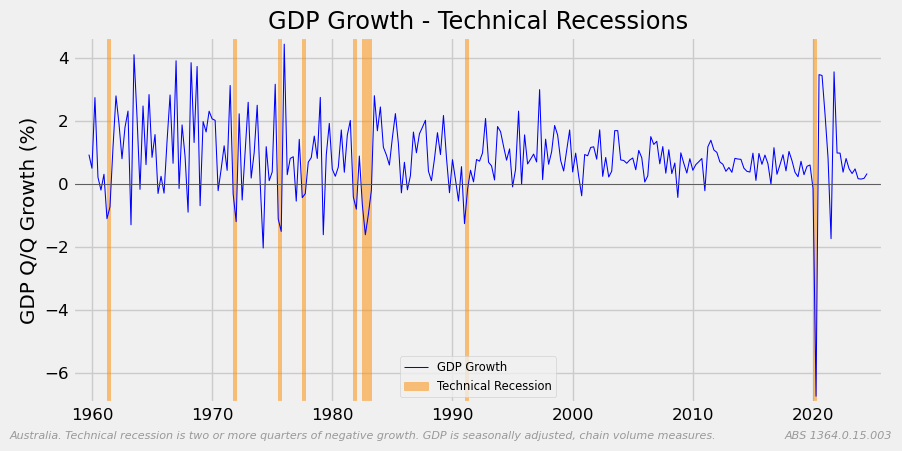

In [8]:
def plot_gdp_tech_rec(data: DataFrame = DATA) -> None:
    """Plot GDP growth and technical recessions."""

    # Technical recession periods
    ax = data["GDP Growth"].plot(lw=0.75, c="blue")
    highlight(
        ax,
        data["GDP Recession"],
        color=R_COLOUR,
        alpha=ALPHA,
        label="Technical Recession",
    )

    finalise_plot(
        ax,
        title="GDP Growth - Technical Recessions",
        ylabel="GDP Q/Q Growth (%)",
        rfooter=rfooter("GDP Growth"),
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. "
        + "GDP is seasonally adjusted, chain volume measures. ",
        **COMMON,
    )


plot_gdp_tech_rec()

### Annual GDP Growth is negative

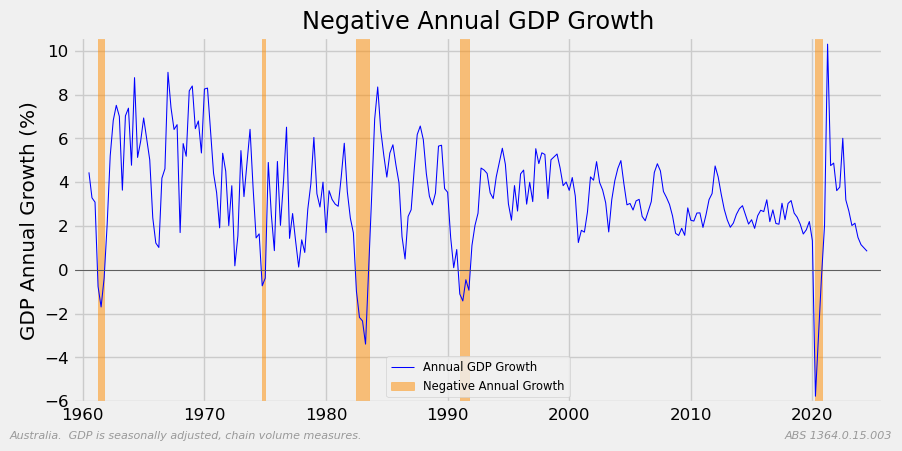

In [9]:
def plot_neg_annual_gdp(data: DataFrame = DATA) -> None:
    """Plot negative Annual growth."""

    # Technical recession periods
    ax = data["Annual GDP Growth"].plot(lw=0.75, c="blue")
    highlight(
        ax,
        data["Negative Annual GDP Growth"],
        color=R_COLOUR,
        alpha=ALPHA,
        label="Negative Annual Growth",
    )

    finalise_plot(
        ax,
        title="Negative Annual GDP Growth",
        ylabel="GDP Annual Growth (%)",
        rfooter=rfooter("Negative Annual GDP Growth"),
        lfooter=f"{LFOOTER} GDP is seasonally adjusted, chain volume measures. ",
        **COMMON,
    )


plot_neg_annual_gdp()

### Technical recessions in employment growth

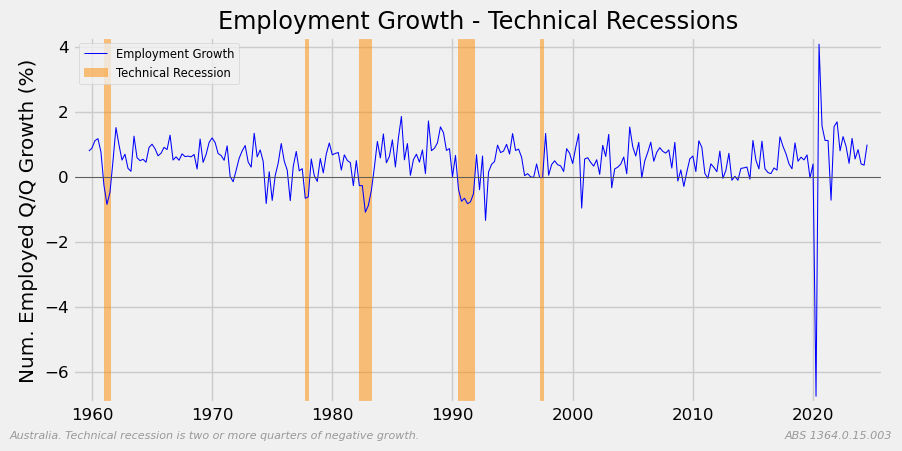

In [10]:
def plot_emp_tech_rec(data: DataFrame = DATA) -> None:
    """Plot employment growth and technical recessions."""

    ax = data["Employment Growth"].plot(lw=0.75, c="blue")
    highlight(
        ax,
        data["Employment Recession"],
        color=R_COLOUR,
        alpha=ALPHA,
        label="Technical Recession",
    )

    finalise_plot(
        ax,
        title="Employment Growth - Technical Recessions",
        ylabel="Num. Employed Q/Q Growth (%)",
        rfooter=rfooter("Employment Growth"),
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. ",
        **COMMON,
    )


plot_emp_tech_rec()

### Technical recessions in GDP per capita growth

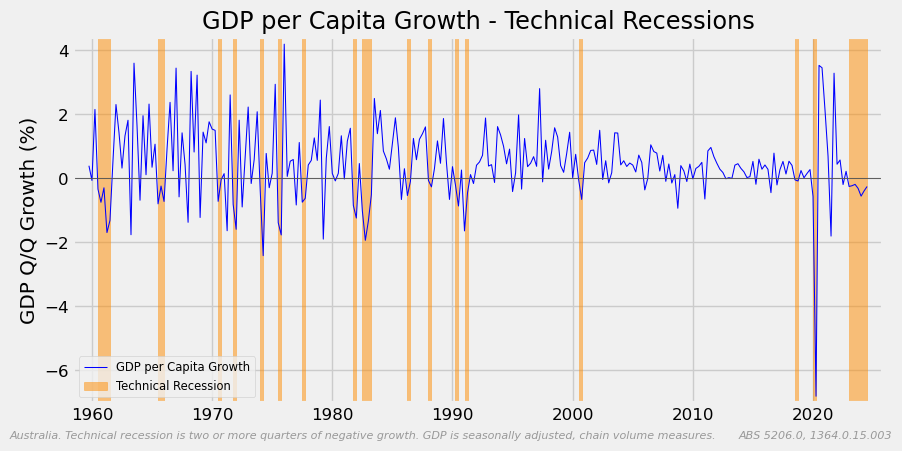

In [11]:
def plot_gdppc_tech_rec(data: DataFrame = DATA) -> None:
    """Plot GDP per capita growth and technical recessions."""

    ax = data["GDP per Capita Growth"].plot(lw=0.75, c="blue")
    highlight(
        ax,
        data["GDP per Capita Recession"],
        color=R_COLOUR,
        alpha=ALPHA,
        label="Technical Recession",
    )

    finalise_plot(
        ax,
        title="GDP per Capita Growth - Technical Recessions",
        ylabel="GDP Q/Q Growth (%)",
        rfooter=rfooter("GDP per Capita Growth"),
        lfooter=f"{LFOOTER}Technical recession is two or more quarters of negative growth. "
        "GDP is seasonally adjusted, chain volume measures. ",
        **COMMON,
    )


plot_gdppc_tech_rec()

### Periods of high growth in the unemployment rate

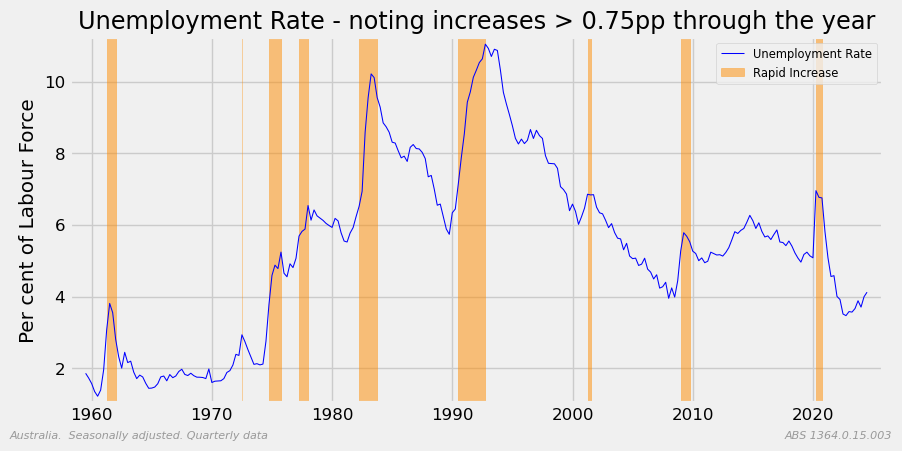

In [12]:
def plot_unemployment(data: DataFrame = DATA) -> None:
    """Plot the unemployment rate and highlight rapid increases."""

    # increase in the unemployment rate
    ax = data["Unemployment Rate"].plot(lw=0.75, c="blue")
    issues = data["Rapid Unemployment Growth"]
    highlight(ax, issues, color=R_COLOUR, alpha=ALPHA, label="Rapid Increase")

    finalise_plot(
        ax,
        title=f"Unemployment Rate - noting increases > {THRESHOLD}pp through the year",
        ylabel="Per cent of Labour Force",
        rfooter=rfooter("Unemployment Rate"),
        lfooter=f"{LFOOTER} Seasonally adjusted. Quarterly data",
        **COMMON,
    )


plot_unemployment()

### Recession = Any two of the above

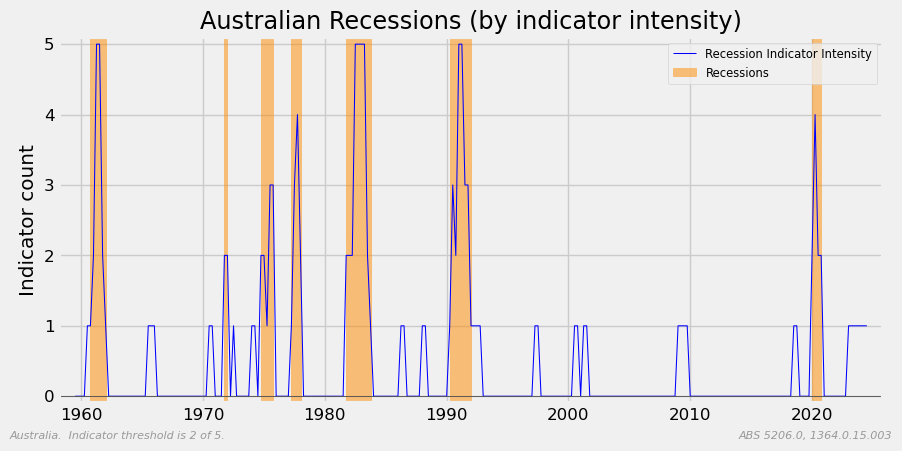

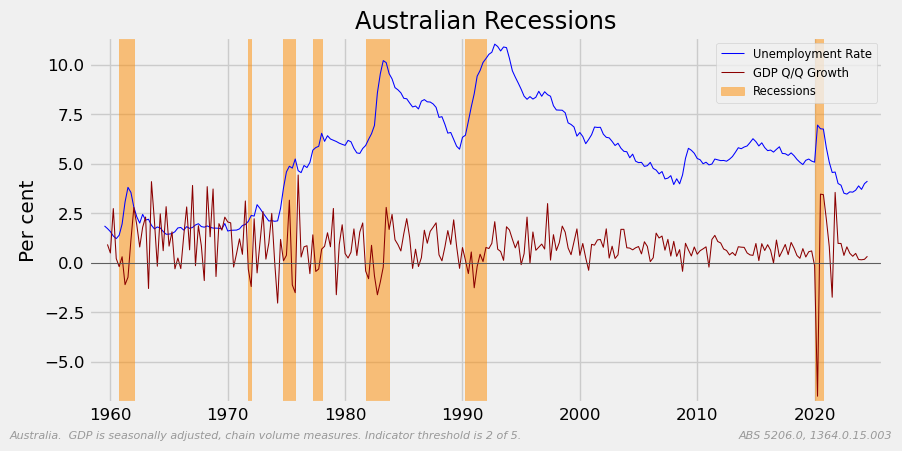

In [13]:
def plot_recessions(data: DataFrame = DATA) -> None:
    """Plot Australian recessions based on above indicators."""

    recession_threshold = 2
    indicator_set = [
        "Rapid Unemployment Growth",
        "GDP per Capita Recession",
        "GDP Recession",
        "Employment Recession",
        "Negative Annual GDP Growth",
    ]

    recession_points = data[indicator_set].sum(axis=1)
    recession = (
        (recession_points >= recession_threshold)
        | ((recession_points >= 1) & (recession_points.shift(1) >= recession_threshold))
        | (
            (recession_points >= 1)
            & (recession_points.shift(-1) >= recession_threshold)
        )
    )

    # chart recession indicator intensity
    ax = recession_points.plot(lw=0.75, c="blue", label="Recession Indicator Intensity")
    highlight(ax, recession, color=R_COLOUR, alpha=ALPHA, label="Recessions")
    finalise_plot(
        ax,
        title="Australian Recessions (by indicator intensity)",
        ylabel="Indicator count",
        rfooter=rfooter("GDP per Capita Growth"),
        lfooter=f"{LFOOTER} "
        + f"Indicator threshold is {recession_threshold} of {len(indicator_set)}. ",
        **COMMON,
    )

    # plot recessions agains GDP and unemployment data
    ax = data["Unemployment Rate"].plot(lw=0.75, c="blue")
    data["GDP Growth"].plot(lw=0.75, c="darkred", ax=ax, label="GDP Q/Q Growth")
    highlight(ax, recession, color=R_COLOUR, alpha=ALPHA, label="Recessions")
    finalise_plot(
        ax,
        title="Australian Recessions",
        ylabel="Per cent",
        rfooter=rfooter("GDP per Capita Growth"),
        lfooter=f"{LFOOTER} "
        "GDP is seasonally adjusted, chain volume measures. "
        + f"Indicator threshold is {recession_threshold} of {len(indicator_set)}. ",
        **COMMON,
    )


plot_recessions()

## Watermark

In [14]:
# watermark
%load_ext watermark
%watermark --python --machine --conda --iversion --watermark

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

conda environment: 312

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

matplotlib: 3.10.0
readabs   : 0.0.24
pandas    : 2.2.3
IPython   : 8.31.0

Watermark: 2.5.0

